# Project 3: Aerial Scene Multi-class Image Classification 

Deep Learning Task: Classification of Google Earth/Satellite images across 30 different classes of aerial scenes (parks, bridges, residential areas, commericial buildings, etc.)

Dataset:
AID is a new large-scale aerial image dataset of sample images from Google Earth imagery. Available on Kaggle here: https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets. Images in AID are multi-source, as Google Earth images are from different remote imaging sensors. All the sample images per each class in AID are carefully chosen from different countries and regions around the world, mainly in China, the United States, England, France, Italy, Japan, Germany, etc., and they are extracted at different time and seasons under different imaging conditions, which increases the intra-class diversities of the data.




References:
- https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets
- https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5
- https://mlwhiz.com/blog/2020/06/06/multiclass_image_classification_pytorch/ 

In [ ]:
# import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob
import shutil
import math
from timeit import default_timer as timer
import itertools

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models 
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from skimage.transform import rescale

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Data

In [ ]:
# unzip downloaded data

!unzip "/content/drive/MyDrive/data690-dl/Projects/Practical Deep Learning Projects/Project 3/data/AID_Satellite_Scene_Classification.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/AID/Mountain/mountain_289.jpg  
  inflating: /content/AID/Mountain/mountain_29.jpg  
  inflating: /content/AID/Mountain/mountain_290.jpg  
  inflating: /content/AID/Mountain/mountain_291.jpg  
  inflating: /content/AID/Mountain/mountain_292.jpg  
  inflating: /content/AID/Mountain/mountain_293.jpg  
  inflating: /content/AID/Mountain/mountain_294.jpg  
  inflating: /content/AID/Mountain/mountain_295.jpg  
  inflating: /content/AID/Mountain/mountain_296.jpg  
  inflating: /content/AID/Mountain/mountain_297.jpg  
  inflating: /content/AID/Mountain/mountain_298.jpg  
  inflating: /content/AID/Mountain/mountain_299.jpg  
  inflating: /content/AID/Mountain/mountain_3.jpg  
  inflating: /content/AID/Mountain/mountain_30.jpg  
  inflating: /content/AID/Mountain/mountain_300.jpg  
  inflating: /content/AID/Mountain/mountain_301.jpg  
  inflating: /content/AID/Mountain/mountain_302.jpg  
  inflating: /content/AID/Mountain/

# 2. Data Cleaning/Wrangling

In [ ]:
# create dataframe of datafiles

data_dir = 'AID/'
classes = os.listdir(data_dir)
data_df = pd.DataFrame()
for class_ in classes:
    path = os.path.join(data_dir, class_)
    df = pd.DataFrame({'path': glob(os.path.join(path,'**.jpg'))}) # load the filenames
    data_df = pd.concat([data_df,df])

In [ ]:
# get image ids
data_df['id'] = data_df.path.map(lambda x: x.split('/')[2].split(".")[0])

# get labels
data_df['label'] = data_df.path.map(lambda x: x.split('/')[1].split(".")[0])
data_df

path                     id  \
0    AID/MediumResidential/mediumresidential_165.jpg  mediumresidential_165   
1    AID/MediumResidential/mediumresidential_219.jpg  mediumresidential_219   
2    AID/MediumResidential/mediumresidential_241.jpg  mediumresidential_241   
3     AID/MediumResidential/mediumresidential_93.jpg   mediumresidential_93   
4    AID/MediumResidential/mediumresidential_159.jpg  mediumresidential_159   
..                                               ...                    ...   
355            AID/StorageTanks/storagetanks_294.jpg       storagetanks_294   
356            AID/StorageTanks/storagetanks_358.jpg       storagetanks_358   
357             AID/StorageTanks/storagetanks_62.jpg        storagetanks_62   
358              AID/StorageTanks/storagetanks_6.jpg         storagetanks_6   
359            AID/StorageTanks/storagetanks_117.jpg       storagetanks_117   

                 label  
0    MediumResidential  
1    MediumResidential  
2    MediumResidential  
3    MediumResidential  
4    MediumResidential  
..                 ...  
355       StorageTanks  
356       StorageTanks  
357       StorageTanks  
358       StorageTanks  
359       StorageTanks  

[10000 rows x 3 columns]

In [ ]:
# create train, test, and validation sets

X_train, X_test, _, _ = train_test_split(
        data_df, data_df['label'],stratify=data_df['label'], test_size=0.3, random_state=0)

X_test, X_val, _, _ = train_test_split(
        X_test, X_test['label'], stratify=X_test['label'], test_size=0.5, random_state=0)

X_train['data_subset'] = 'train'
X_val['data_subset'] = 'val'
X_test['data_subset'] = 'test'

full_data_df = pd.concat([X_train,X_test,X_val])

In [ ]:
# view final data

full_data_df

path                     id  \
53         AID/RailwayStation/railwaystation_173.jpg     railwaystation_173   
97                          AID/Center/center_13.jpg              center_13   
232                          AID/Beach/beach_339.jpg              beach_339   
312                            AID/Pond/pond_115.jpg               pond_115   
51                 AID/Playground/playground_294.jpg         playground_294   
..                                               ...                    ...   
101                            AID/Port/port_274.jpg               port_274   
141  AID/MediumResidential/mediumresidential_174.jpg  mediumresidential_174   
238                AID/Playground/playground_352.jpg         playground_352   
245         AID/RailwayStation/railwaystation_50.jpg      railwaystation_50   
275                         AID/Meadow/meadow_51.jpg              meadow_51   

                 label data_subset  
53      RailwayStation       train  
97              Center       train  
232              Beach       train  
312               Pond       train  
51          Playground       train  
..                 ...         ...  
101               Port         val  
141  MediumResidential         val  
238         Playground         val  
245     RailwayStation         val  
275             Meadow         val  

[10000 rows x 4 columns]

In [ ]:
# view the size of train, test, validation datasets

full_data_df.data_subset.value_counts()

train    7000
test     1500
val      1500
Name: data_subset, dtype: int64

In [ ]:
# create train, test, validation folders

!mkdir data
!rm -rf data/
!rm -rf data/train
!rm -rf data/test
!rm -rf data/val
!mkdir data/
!mkdir data/train
!mkdir data/test
!mkdir data/val

In [ ]:
# make directories for each of the 30 classes within train, test, val folders 

for cat in full_data_df.label.unique():
    os.system(f"mkdir data/train/'{cat}'") 
    os.system(f"mkdir data/test/'{cat}'") 
    os.system(f"mkdir data/val/'{cat}'") 

In [ ]:
# move images to corresponding class in train, test, val folders

progress = 0
for i,row in full_data_df.iterrows():
    # monitor progress
    progress+=1
    if progress % 1000 == 0:
        print(progress)
    # Boat category
    cat = row['label']
    # section is train,val or test
    section = row['data_subset']
    # input filepath to copy
    ipath = row['path']
    # output filepath to paste
    opath = ipath.replace(f"AID/",f"data/{section}/")
    # running the cp command
    os.system(f"cp '{ipath}' '{opath}'")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


# 3. EDA/View the data

In [ ]:
# view length of data

len(full_data_df.path)

10000

In [ ]:
#number of classes

n_classes = full_data_df.label.nunique()
n_classes

30

In [ ]:
# view class names
classes

['MediumResidential',
 'Mountain',
 'Park',
 'Pond',
 'Commercial',
 'Viaduct',
 'Resort',
 'Meadow',
 'BaseballField',
 'Playground',
 'RailwayStation',
 'Airport',
 'Church',
 'Square',
 'DenseResidential',
 'Port',
 'School',
 'Industrial',
 'Stadium',
 'Beach',
 'BareLand',
 'Center',
 'Parking',
 'SparseResidential',
 'Farmland',
 'River',
 'Bridge',
 'Desert',
 'Forest',
 'StorageTanks']

In [ ]:
# all unique classes
full_data_df.label.unique()

array(['RailwayStation', 'Center', 'Beach', 'Pond', 'Playground', 'Port',
       'Commercial', 'BareLand', 'Airport', 'Bridge', 'School',
       'DenseResidential', 'Mountain', 'Desert', 'Industrial',
       'MediumResidential', 'Square', 'Viaduct', 'BaseballField', 'River',
       'Church', 'StorageTanks', 'Forest', 'Park', 'Farmland',
       'SparseResidential', 'Resort', 'Meadow', 'Parking', 'Stadium'],
      dtype=object)

In [ ]:
# describe data

full_data_df.describe()

path                  id  label  \
count                                       10000               10000  10000   
unique                                      10000               10000     30   
top     AID/RailwayStation/railwaystation_173.jpg  railwaystation_173   Pond   
freq                                            1                   1    420   

       data_subset  
count        10000  
unique           3  
top          train  
freq          7000

In [ ]:
# distribution of images count per class

full_data_df['label'].value_counts()

Pond                 420
Viaduct              420
DenseResidential     410
River                410
Beach                400
Industrial           390
Parking              390
Port                 380
Farmland             370
Playground           370
Bridge               360
Airport              360
StorageTanks         360
Park                 350
Commercial           350
Mountain             340
Square               330
BareLand             310
School               300
Desert               300
SparseResidential    300
Resort               290
MediumResidential    290
Stadium              290
Meadow               280
Center               260
RailwayStation       260
Forest               250
Church               240
BaseballField        220
Name: label, dtype: int64

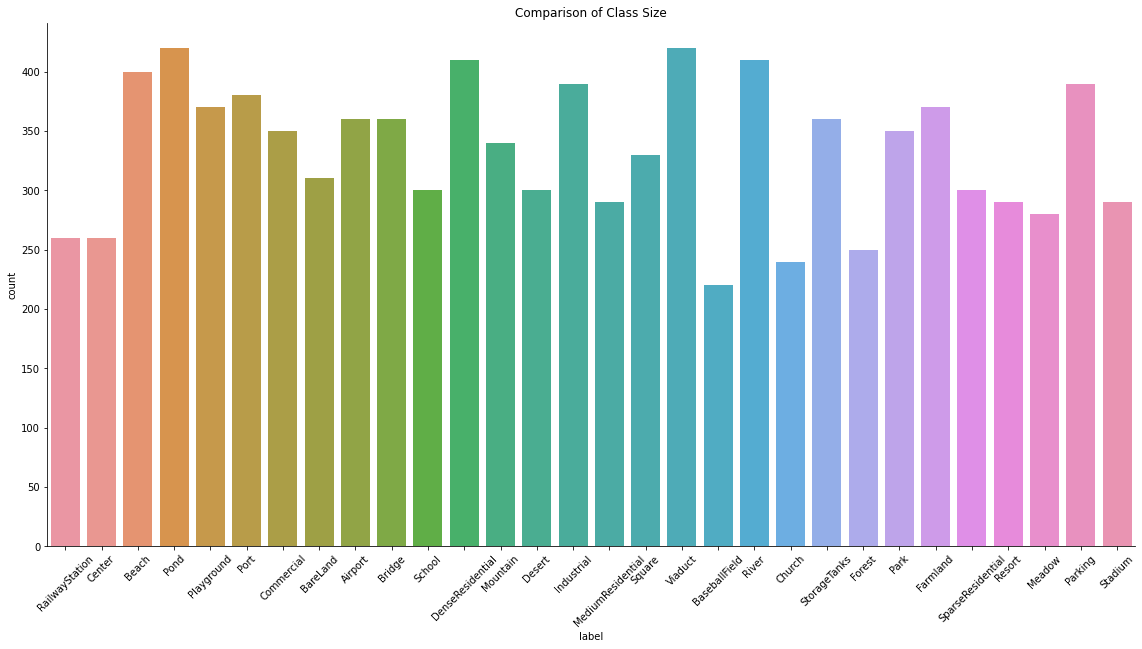

In [ ]:
# visualize the count of images by class

fig = sns.catplot(x='label', kind='count', data=full_data_df, height=8, aspect=2)
plt.xticks(rotation=45)
plt.title('Comparison of Class Size')
plt.show(fig)

# 4. Prepare Data for Modeling

In [ ]:
class CustomImageDataset(Dataset):

    # initialize class methods
    def __init__(self, label_df, data_dir, batch_size=32, transform=None, test_transform=None):
        self.img_labels = label_df
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform
        self.test_transform = test_transform

    # return length of image data
    def __len__(self):
        return len(self.img_labels)

    # examine individual images by class
    def __getitem__(self, idx=0, data_subset='train', cat='Airport'):
        data_subdir = os.path.join(self.data_dir, data_subset)
        img_dir = os.path.join(data_subdir, cat)
        images_in_dir = os.listdir(img_dir)
        img_path = os.path.join(img_dir, images_in_dir[idx])
        print(cat)
        print(img_path)
        image = io.imread(img_path)
        print(image.shape)
        image = cv2.resize(image, (200, 200))

        return cv2_imshow(image)

    # create DataLoaders for modeling    
    def __load_data__(self):
        if self.transform:
            transform = self.transform
        if self.test_transform:
            test_transform = self.test_transform

        # set the training dataset & test dataset with the appropriate file path and pass transformations
        train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'train'), transform=transform)
        val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'val'), transform=test_transform)
        test_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'test'), transform=test_transform)

        # create DataLoader objects
        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train, train_dataset, val, val_dataset, test, test_dataset

In [ ]:
# transforms for the training, testing, and validation data

transforms_train = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# create instance of custom image class

AID_CNN = CustomImageDataset(label_df=data_df, 
                                   data_dir='/content/data/', 
                                   batch_size=10,
                                   transform=transforms_train, 
                                   test_transform=transforms_test)

Park
/content/data/train/Park/park_217.jpg
(600, 600, 3)


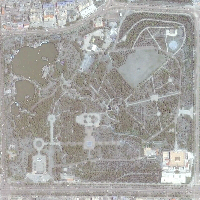

Resort
/content/data/train/Resort/resort_161.jpg
(600, 600, 3)


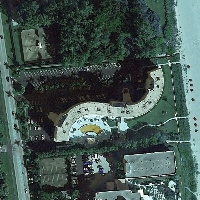

Forest
/content/data/train/Forest/forest_50.jpg
(600, 600, 3)


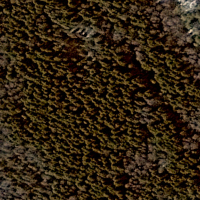

In [ ]:
# view example images

AID_CNN.__getitem__(cat='Park')
AID_CNN.__getitem__(cat='Resort')
AID_CNN.__getitem__(cat='Forest')

In [ ]:
# get DataLoader objects for modeling

train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = AID_CNN.__load_data__()

# 5. Define Model architecture 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# load model for transfer learning

# transfer learning with pretrained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# trainable fully connected layer for classification
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# Move model to GPU if available
if train_on_gpu: model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# model parameters

# define learning rate 
lr = 0.001
# define number of epochs
n_epochs = 20
# specify the loss function of CrossEntropyLoss since we are dealing with multiple classes
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# define paath for model saving
save_file_name = 'best_model.pt'

# 6. Train CNN Model

In [ ]:
# create function for training PyTorch model

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """
    Train PyTorch Model

    Parameters:
    ———————————
        model: PyTorch model
            cnn to train
        criterion: loss function 
            objective to minimize
        optimizer: optimizier
            optimizer to compute gradients of model parameters
        train_loader: PyTorch dataloader object 
            training dataloader to iterate through
        valid_loader: PyTorch dataloader object
            validation dataloader used for early stopping
        save_file_name: str ending in '.pt'
            file path to save the model state dict
        max_epochs_stop: int
            maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs: int
            maximum number of training epochs
        print_every: int 
            frequency of epochs to print training stats

    Outputs:
    ————————
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights from previous training)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Begin Training from epoch {model.epochs}.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()

            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                # save model performance stats
                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history

In [ ]:
# train model

model_1, history_1 = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=n_epochs,
    print_every=1)

Begin Training from epoch 0.


Epoch: 0 	Training Loss: 1.7950 	Validation Loss: 0.9045
		Training Accuracy: 50.41%	 Validation Accuracy: 75.07%

Epoch: 1 	Training Loss: 1.0010 	Validation Loss: 0.6476
		Training Accuracy: 69.40%	 Validation Accuracy: 81.07%

Epoch: 2 	Training Loss: 0.8264 	Validation Loss: 0.5663
		Training Accuracy: 74.89%	 Validation Accuracy: 83.47%

Epoch: 3 	Training Loss: 0.7442 	Validation Loss: 0.5242
		Training Accuracy: 76.91%	 Validation Accuracy: 83.60%

Epoch: 4 	Training Loss: 0.7104 	Validation Loss: 0.4849
		Training Accuracy: 78.76%	 Validation Accuracy: 85.33%

Epoch: 5 	Training Loss: 0.6756 	Validation Loss: 0.5189
		Training Accuracy: 79.14%	 Validation Accuracy: 83.87%

Epoch: 6 	Training Loss: 0.6237 	Validation Loss: 0.4892
		Training Accuracy: 80.86%	 Validation Accuracy: 84.80%

Epoch: 7 	Training Loss: 0.6356 	Validation Loss: 0.4752
		Training Accuracy: 80.20%	 Validation Accuracy: 85.27%

Epoch: 8 	Training Loss: 0.5935 	Validation Loss:

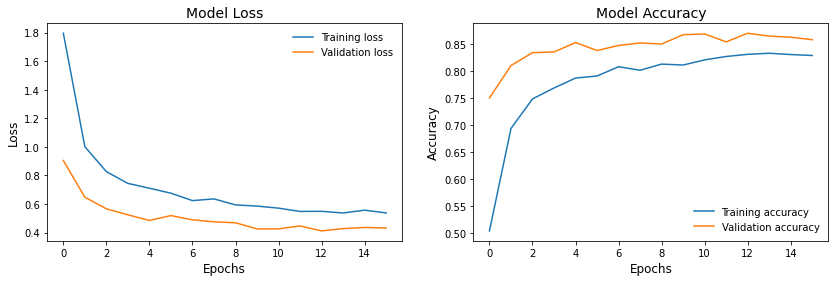

In [ ]:
# plot loss and accuracy

fig, ax = plt.subplots(1,2,figsize=(14,4))

# plot loss
ax[0].plot(history_1.train_loss, label='Training loss')
ax[0].plot(history_1.valid_loss, label='Validation loss')
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].set_title("Model Loss", fontsize=14)
ax[0].legend(frameon=False)

# plot accuracy
ax[1].plot(history_1.train_acc, label='Training accuracy')
ax[1].plot(history_1.valid_acc, label='Validation accuracy')
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].set_title("Model Accuracy", fontsize=14)
ax[1].legend(frameon=False)

plt.show()

# 7. Model Evaluation and Inference

## 7.1. Helper Functions for Model Evaluation and Inference

In [ ]:
def imshow(img):
    '''
    Helper function to un-normalize and display an image
    '''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
def accuracy(output, target, topk=(1, )):
    """
    Compute the accuracy for top k number of predicted classes
    """
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res


In [ ]:
def evaluate(model, test_loader, criterion, topk=(1, 3, 5)):
    """
    Test model inference on test set

    Parameters:
    ———————————
        model: PyTorch model
            trained cnn for inference
        test_loader: PyTorch DataLoader
            test dataloader
        topk: tuple of ints:
            accuracy to measure

    Outputs:
    ————————
        results: DataFrame
            results for each category
    """
    confusion_matrix = torch.zeros(full_data_df.label.nunique(), full_data_df.label.nunique())
    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, full_data_df.label.nunique()), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}), confusion_matrix


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Function to plot the confusion matrix
    '''
    cm = np.array(cm).astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # generate confusion matrix plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # confusion matrix ormatting 
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix.png')
    return plt


In [ ]:
def predict_image(image,model,topk=3):
    '''
    function for predicting the class of a given image

    Parameters:
    ———————————
    image: PIL Image
        the image to inference
    model: trained PyTorch model
        model used for prediction
    topk: int
        the number of most probable classes to return
    '''
    image_tensor = transforms_test(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    if train_on_gpu:
        input = input.view(1, 3, 200, 200).cuda()
    else:
        input = input.view(1, 3, 200, 200)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()

    with torch.no_grad():
        # Model outputs log probabilities
        out = model(input)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

    return index, top_classes

def get_random_images(num):
    '''
    get a sample of random images from test data for inference
    
    Parameters:
    ———————————
    num: int
        the number of images to return

    Outputs:
    ————————
    images: tensor
        the images selected
    labels: list
        correct labels for images
    classes: list
        the list of image classes
    '''
    data = datasets.ImageFolder('data/test', transform=transforms_test)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels, classes

## 7.2. Evaluate on Test data

In [ ]:
# create mapping of class names to index and vice versa

class_to_idx = train_dataset.class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in train_dataset.class_to_idx.items()}

model_1.class_to_idx = train_dataset.class_to_idx
model_1.idx_to_class = {
    idx: class_
    for class_, idx in model_1.class_to_idx.items()
}

list(model_1.idx_to_class.items())[:10]


[(0, 'Airport'),
 (1, 'BareLand'),
 (2, 'BaseballField'),
 (3, 'Beach'),
 (4, 'Bridge'),
 (5, 'Center'),
 (6, 'Church'),
 (7, 'Commercial'),
 (8, 'DenseResidential'),
 (9, 'Desert')]

In [ ]:
# Evaluate the model on all the test data

results, confusion_matrix = evaluate(model_1, test_loader, criterion)

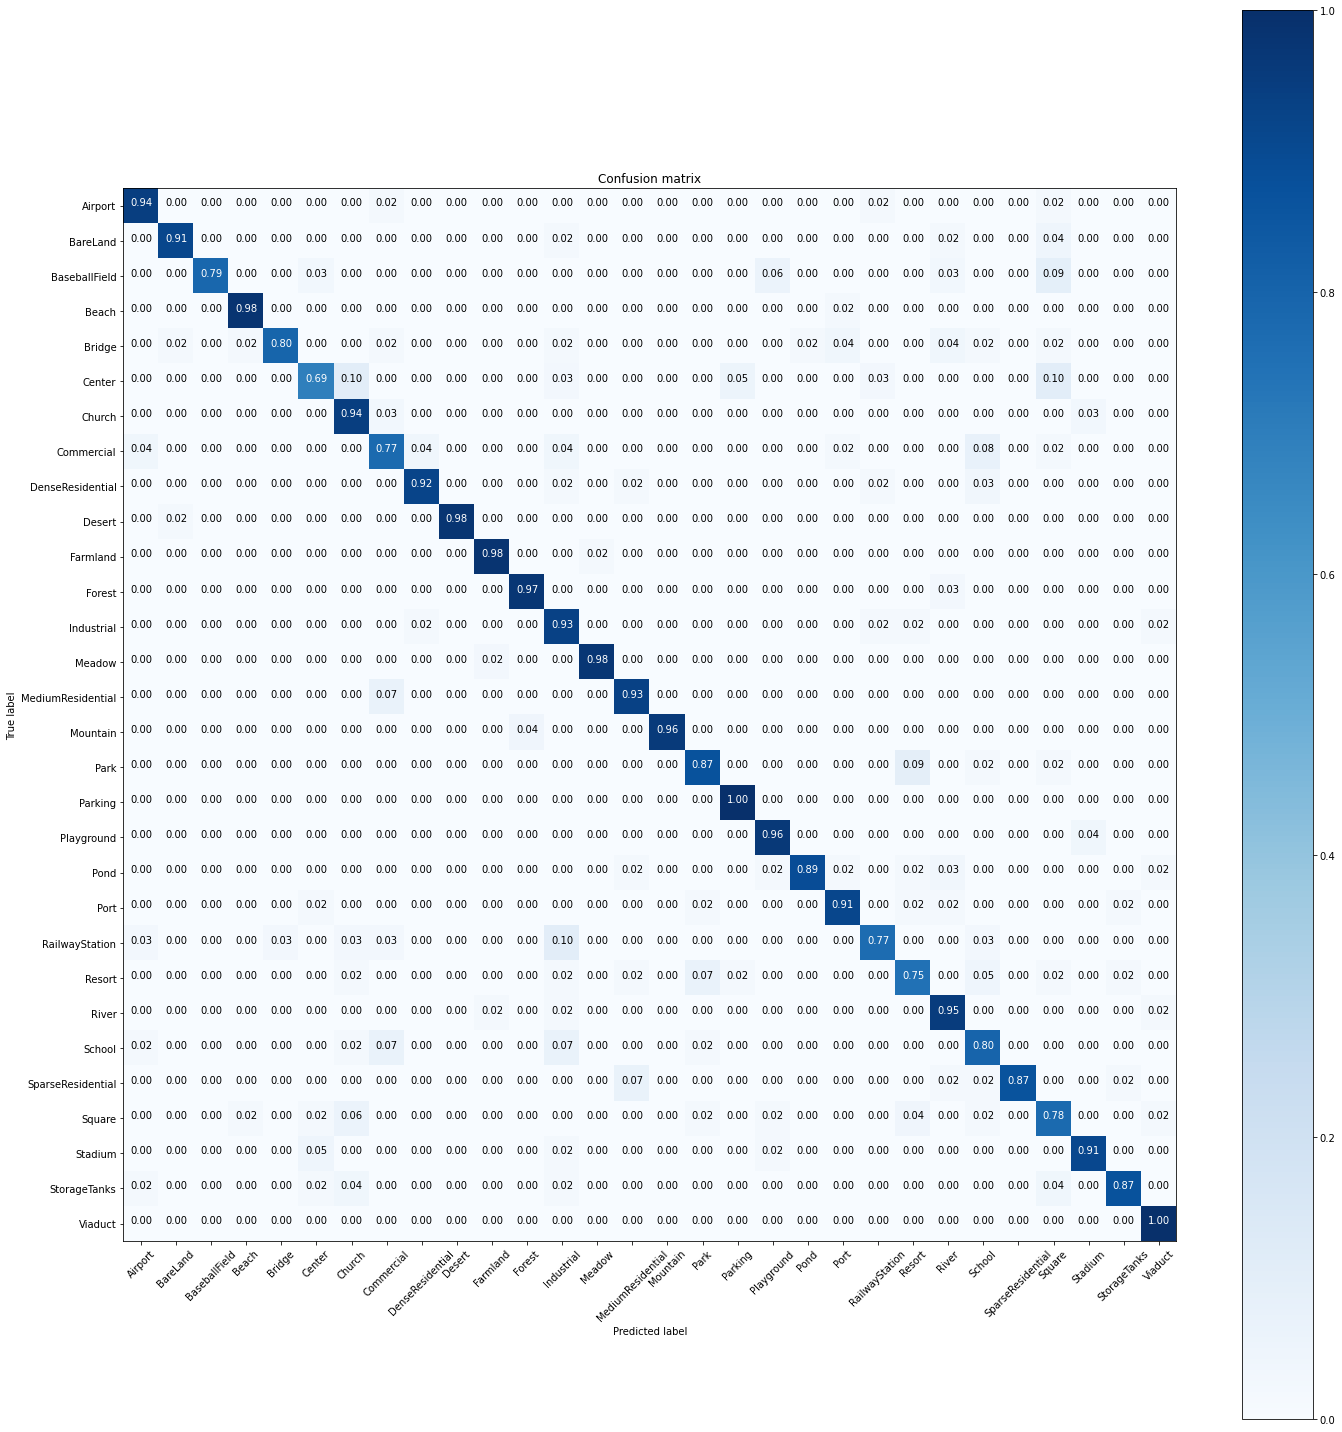

In [ ]:
# get confusion matrix plot

classnames = [model_1.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(20,20))
cfm_plot = plot_confusion_matrix(confusion_matrix, classnames)

In [ ]:
# compute test accuracy

test_acc = round(float(confusion_matrix.diag().sum()/confusion_matrix.sum())*100, 2)
print(f"Overall Accuracy: {test_acc}%")

Overall Accuracy: 89.93%


## 7.3. Model Inference

In [ ]:
# load model for inference

model_1.load_state_dict(torch.load('best_model.pt'))
model_1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

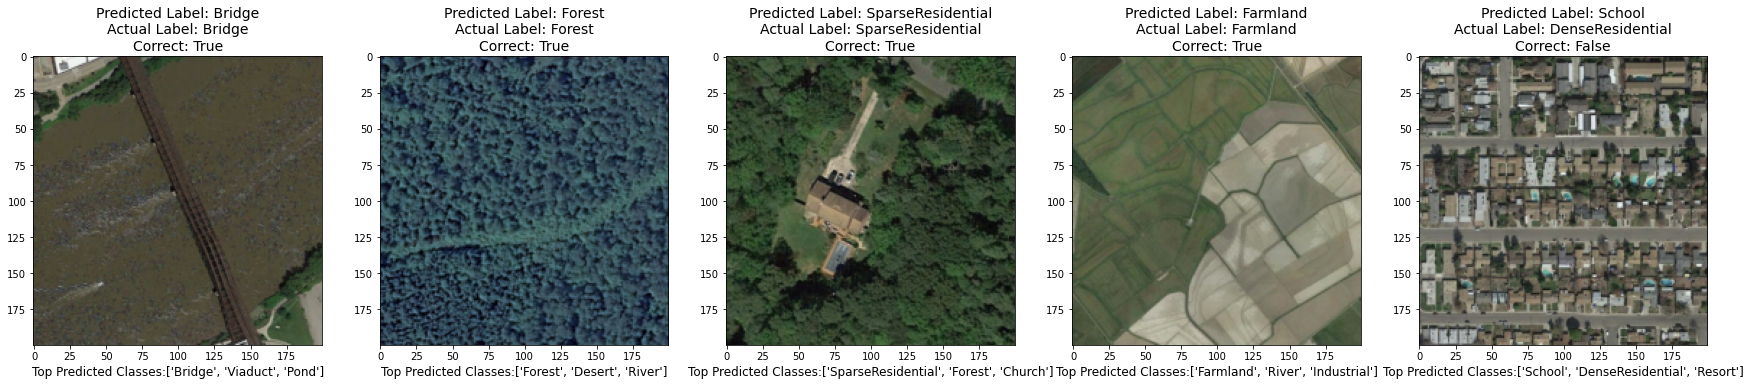

In [ ]:
# examine sample model inference

# convert image format
to_pil = transforms.ToPILImage()
# get sample images
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(30,30))
# make predictions and compare to True labels
for ii in range(len(images)):
    # image formatting for inference
    image = to_pil(images[ii])
    # get predictions
    index, class_probs = predict_image(image, model_1)
    # add to subplot
    sub = fig.add_subplot(1, len(images), ii+1)
    # calculate result
    res = int(labels[ii]) == index
    # predicted vs actual label
    sub.set_title('Predicted Label: ' + str(classes[index]) + '\nActual Label: ' + str(classes[labels[ii]]) + '\nCorrect: ' + str(res), fontsize=14)
    # top 3 most likely image classes according to model
    sub.set_xlabel('Top Predicted Classes:' + str(class_probs), fontsize=12)
    # format for display
    image = images[ii].numpy()
    imshow(image)
plt.show()

# 8. Comparison with VGG16

In [ ]:
# load model for transfer learning

# transfer learning with pretrained ResNet50 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# trainable fully connected layer for classification
# n_inputs = model.fc.in_features
model.classifier[6] = nn.Linear(4096, n_classes)
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 1024), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(1024, 512), 
                      nn.ReLU(),  
                      nn.Linear(512, n_classes),               
                      nn.LogSoftmax(dim=1))

# Move model to GPU if available
if train_on_gpu: model.cuda()

# model parameters

# define learning rate 
lr = 0.001
# define number of epochs
n_epochs = 20
# specify the loss function of CrossEntropyLoss since we are dealing with multiple classes
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# define paath for model saving
save_file_name = 'best_model.pt'

In [ ]:
# train model

model_2, history_2 = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=n_epochs,
    print_every=1)

Begin Training from epoch 0.


Epoch: 0 	Training Loss: 1.3661 	Validation Loss: 0.9435
		Training Accuracy: 59.34%	 Validation Accuracy: 69.27%

Epoch: 1 	Training Loss: 1.0670 	Validation Loss: 0.8367
		Training Accuracy: 68.47%	 Validation Accuracy: 72.67%

Epoch: 2 	Training Loss: 1.0236 	Validation Loss: 0.8711
		Training Accuracy: 69.87%	 Validation Accuracy: 73.33%

Epoch: 3 	Training Loss: 1.0371 	Validation Loss: 0.8328
		Training Accuracy: 69.57%	 Validation Accuracy: 73.93%

Epoch: 4 	Training Loss: 1.0554 	Validation Loss: 0.7334
		Training Accuracy: 70.43%	 Validation Accuracy: 77.33%

Epoch: 5 	Training Loss: 1.0216 	Validation Loss: 0.8122
		Training Accuracy: 72.13%	 Validation Accuracy: 75.73%

Epoch: 6 	Training Loss: 1.0432 	Validation Loss: 0.7149
		Training Accuracy: 71.70%	 Validation Accuracy: 77.73%

Epoch: 7 	Training Loss: 1.0838 	Validation Loss: 0.8009
		Training Accuracy: 70.87%	 Validation Accuracy: 76.07%

Epoch: 8 	Training Loss: 1.0436 	Validation Loss:

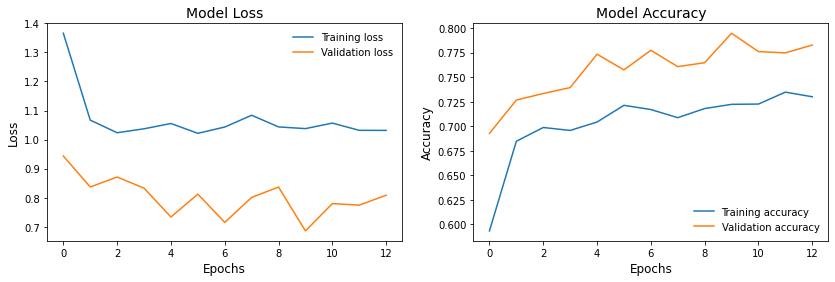

In [ ]:
# plot loss and accuracy

fig, ax = plt.subplots(1,2,figsize=(14,4))

# plot loss
ax[0].plot(history_2.train_loss, label='Training loss')
ax[0].plot(history_2.valid_loss, label='Validation loss')
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].set_title("Model Loss", fontsize=14)
ax[0].legend(frameon=False)

# plot accuracy
ax[1].plot(history_2.train_acc, label='Training accuracy')
ax[1].plot(history_2.valid_acc, label='Validation accuracy')
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].set_title("Model Accuracy", fontsize=14)
ax[1].legend(frameon=False)

plt.show()

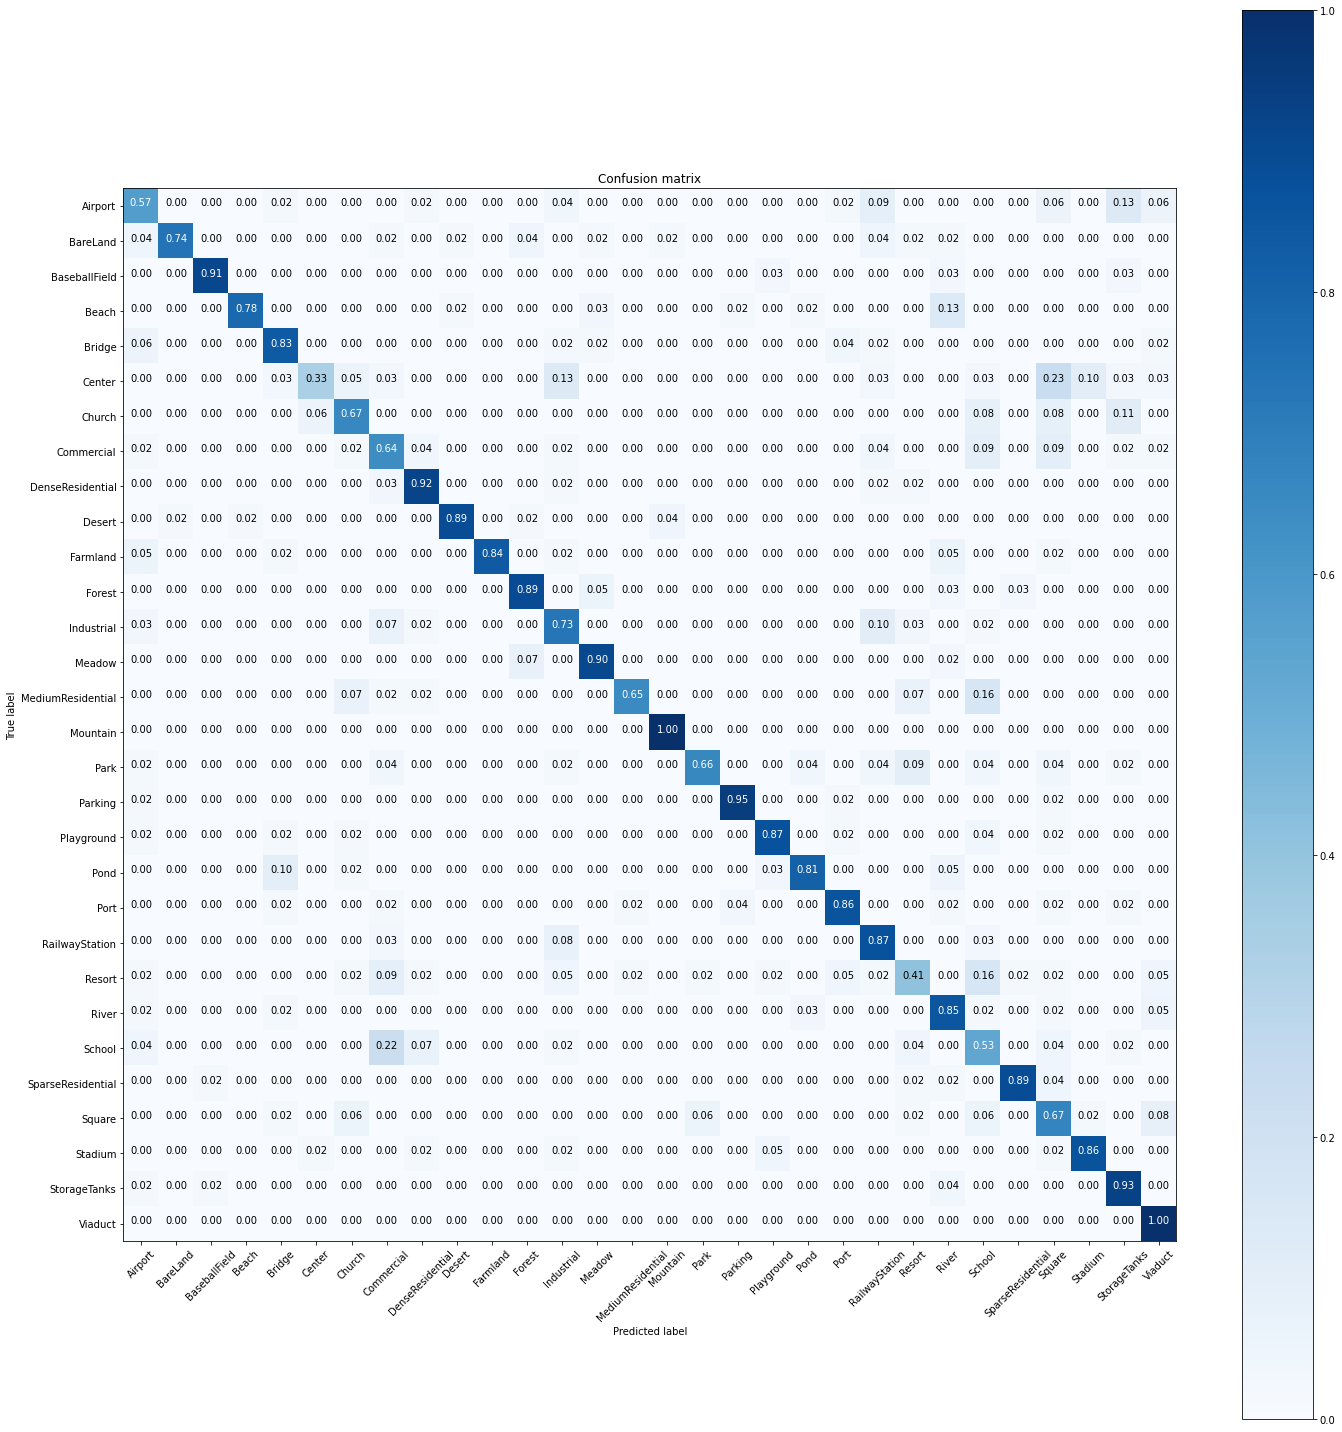

In [ ]:
# create mapping of class names to index and vice versa

class_to_idx = train_dataset.class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in train_dataset.class_to_idx.items()}

model_2.class_to_idx = train_dataset.class_to_idx
model_2.idx_to_class = {
    idx: class_
    for class_, idx in model_2.class_to_idx.items()
}

# Evaluate the model on all the test data

results, confusion_matrix = evaluate(model_2, test_loader, criterion)

# get confusion matrix plot

classnames = [model_2.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(20,20))
cfm_plot = plot_confusion_matrix(confusion_matrix, classnames)

In [ ]:
# compute test accuracy

test_acc = round(float(confusion_matrix.diag().sum()/confusion_matrix.sum())*100, 2)
print(f"Overall Accuracy: {test_acc}%")

Overall Accuracy: 79.0%


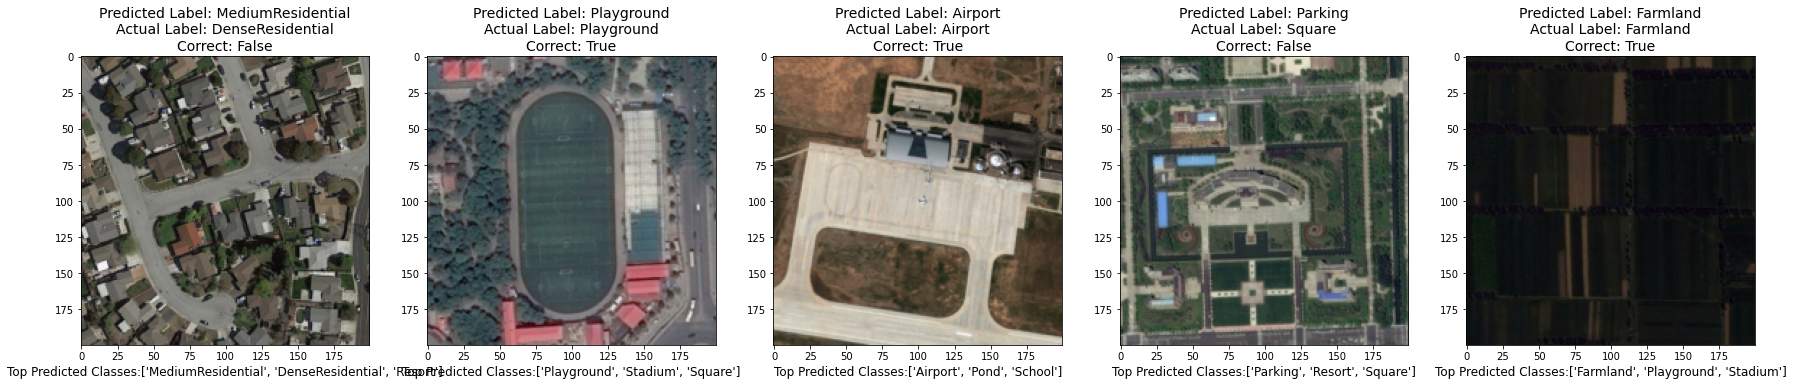

In [ ]:
# examine sample model inference

# load model for inference
model_2.load_state_dict(torch.load('best_model.pt'))
model_2.eval()

# convert image format
to_pil = transforms.ToPILImage()
# get sample images
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(30,30))
# make predictions and compare to True labels
for ii in range(len(images)):
    # image formatting for inference
    image = to_pil(images[ii])
    # get predictions
    index, class_probs = predict_image(image, model_2)
    # add to subplot
    sub = fig.add_subplot(1, len(images), ii+1)
    # calculate result
    res = int(labels[ii]) == index
    # predicted vs actual label
    sub.set_title('Predicted Label: ' + str(classes[index]) + '\nActual Label: ' + str(classes[labels[ii]]) + '\nCorrect: ' + str(res), fontsize=14)
    # top 3 most likely image classes according to model
    sub.set_xlabel('Top Predicted Classes:' + str(class_probs), fontsize=12)
    # format for display
    image = images[ii].numpy()
    imshow(image)
plt.show()

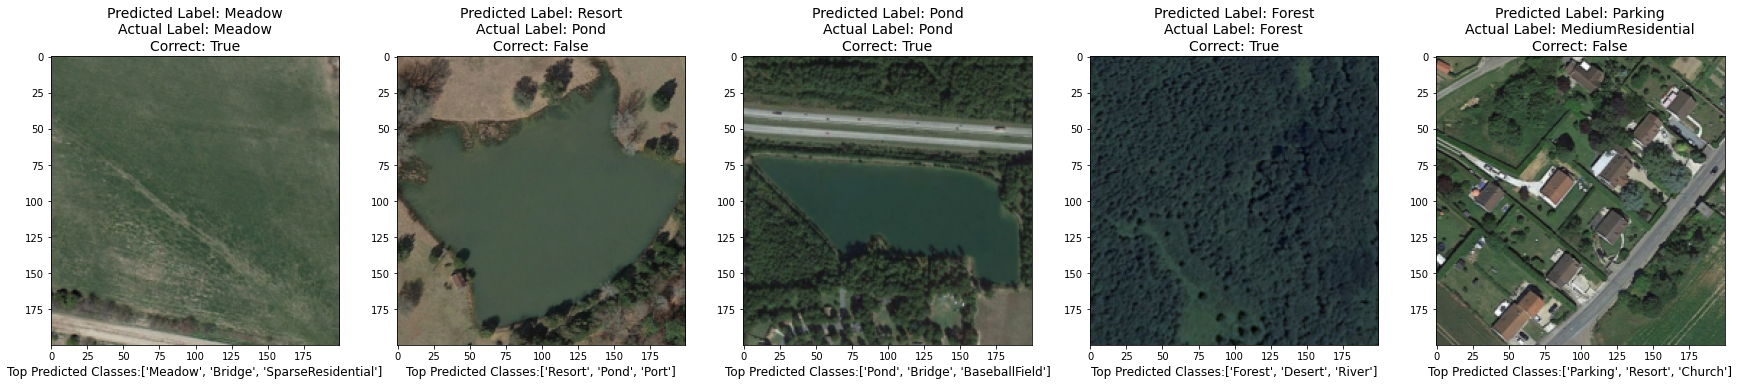

In [ ]:
# examine another sample model inference

# load model for inference
model_2.load_state_dict(torch.load('best_model.pt'))
model_2.eval()

# convert image format
to_pil = transforms.ToPILImage()
# get sample images
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(30,30))
# make predictions and compare to True labels
for ii in range(len(images)):
    # image formatting for inference
    image = to_pil(images[ii])
    # get predictions
    index, class_probs = predict_image(image, model_2)
    # add to subplot
    sub = fig.add_subplot(1, len(images), ii+1)
    # calculate result
    res = int(labels[ii]) == index
    # predicted vs actual label
    sub.set_title('Predicted Label: ' + str(classes[index]) + '\nActual Label: ' + str(classes[labels[ii]]) + '\nCorrect: ' + str(res), fontsize=14)
    # top 3 most likely image classes according to model
    sub.set_xlabel('Top Predicted Classes:' + str(class_probs), fontsize=12)
    # format for display
    image = images[ii].numpy()
    imshow(image)
plt.show()

# 9. Comparison with Basic CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=16,kernel_size=2,stride=1,padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=16,out_channels=32,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=128,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        self.fc=nn.Sequential(
                nn.Linear(128*25*25,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, n_classes),
                nn.LogSoftmax(dim=1))
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

# instantiate model
model = CNN()

# Move model to GPU if available
if train_on_gpu: model.cuda()

# model parameters

# define learning rate 
lr = 0.001
# define number of epochs
n_epochs = 10
# specify the loss function of CrossEntropyLoss since we are dealing with multiple classes
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# define paath for model saving
save_file_name = 'best_model.pt'

In [ ]:
# train model

model_3, history_3 = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=n_epochs,
    print_every=1)

Begin Training from epoch 0.


Epoch: 0 	Training Loss: 4.6574 	Validation Loss: 3.3386
		Training Accuracy: 4.63%	 Validation Accuracy: 5.60%

Epoch: 1 	Training Loss: 3.3507 	Validation Loss: 3.2940
		Training Accuracy: 4.89%	 Validation Accuracy: 6.27%

Epoch: 2 	Training Loss: 3.3339 	Validation Loss: 3.2995
		Training Accuracy: 5.87%	 Validation Accuracy: 6.07%

Epoch: 3 	Training Loss: 3.3134 	Validation Loss: 3.2457
		Training Accuracy: 5.84%	 Validation Accuracy: 7.47%

Epoch: 4 	Training Loss: 3.3230 	Validation Loss: 3.2435
		Training Accuracy: 6.01%	 Validation Accuracy: 8.13%

Epoch: 5 	Training Loss: 3.3257 	Validation Loss: 3.2551
		Training Accuracy: 6.00%	 Validation Accuracy: 7.73%

Epoch: 6 	Training Loss: 3.3089 	Validation Loss: 3.2496
		Training Accuracy: 6.36%	 Validation Accuracy: 7.53%

Epoch: 7 	Training Loss: 3.3744 	Validation Loss: 3.3810
		Training Accuracy: 5.77%	 Validation Accuracy: 4.40%

Early Stopping! Total epochs: 7. Best epoch: 4 with loss: 3.24 an

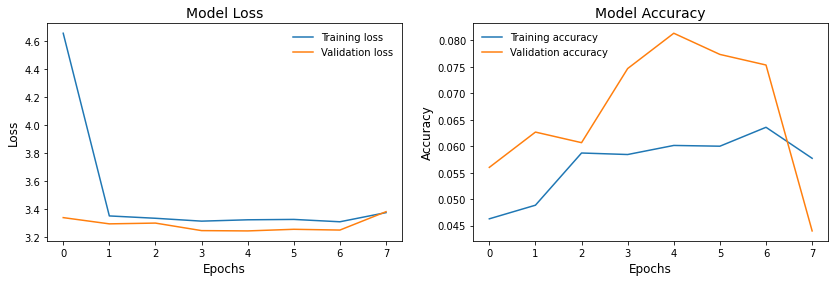

In [ ]:
# plot loss and accuracy

fig, ax = plt.subplots(1,2,figsize=(14,4))

# plot loss
ax[0].plot(history_3.train_loss, label='Training loss')
ax[0].plot(history_3.valid_loss, label='Validation loss')
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].set_title("Model Loss", fontsize=14)
ax[0].legend(frameon=False)

# plot accuracy
ax[1].plot(history_3.train_acc, label='Training accuracy')
ax[1].plot(history_3.valid_acc, label='Validation accuracy')
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].set_title("Model Accuracy", fontsize=14)
ax[1].legend(frameon=False)

plt.show()

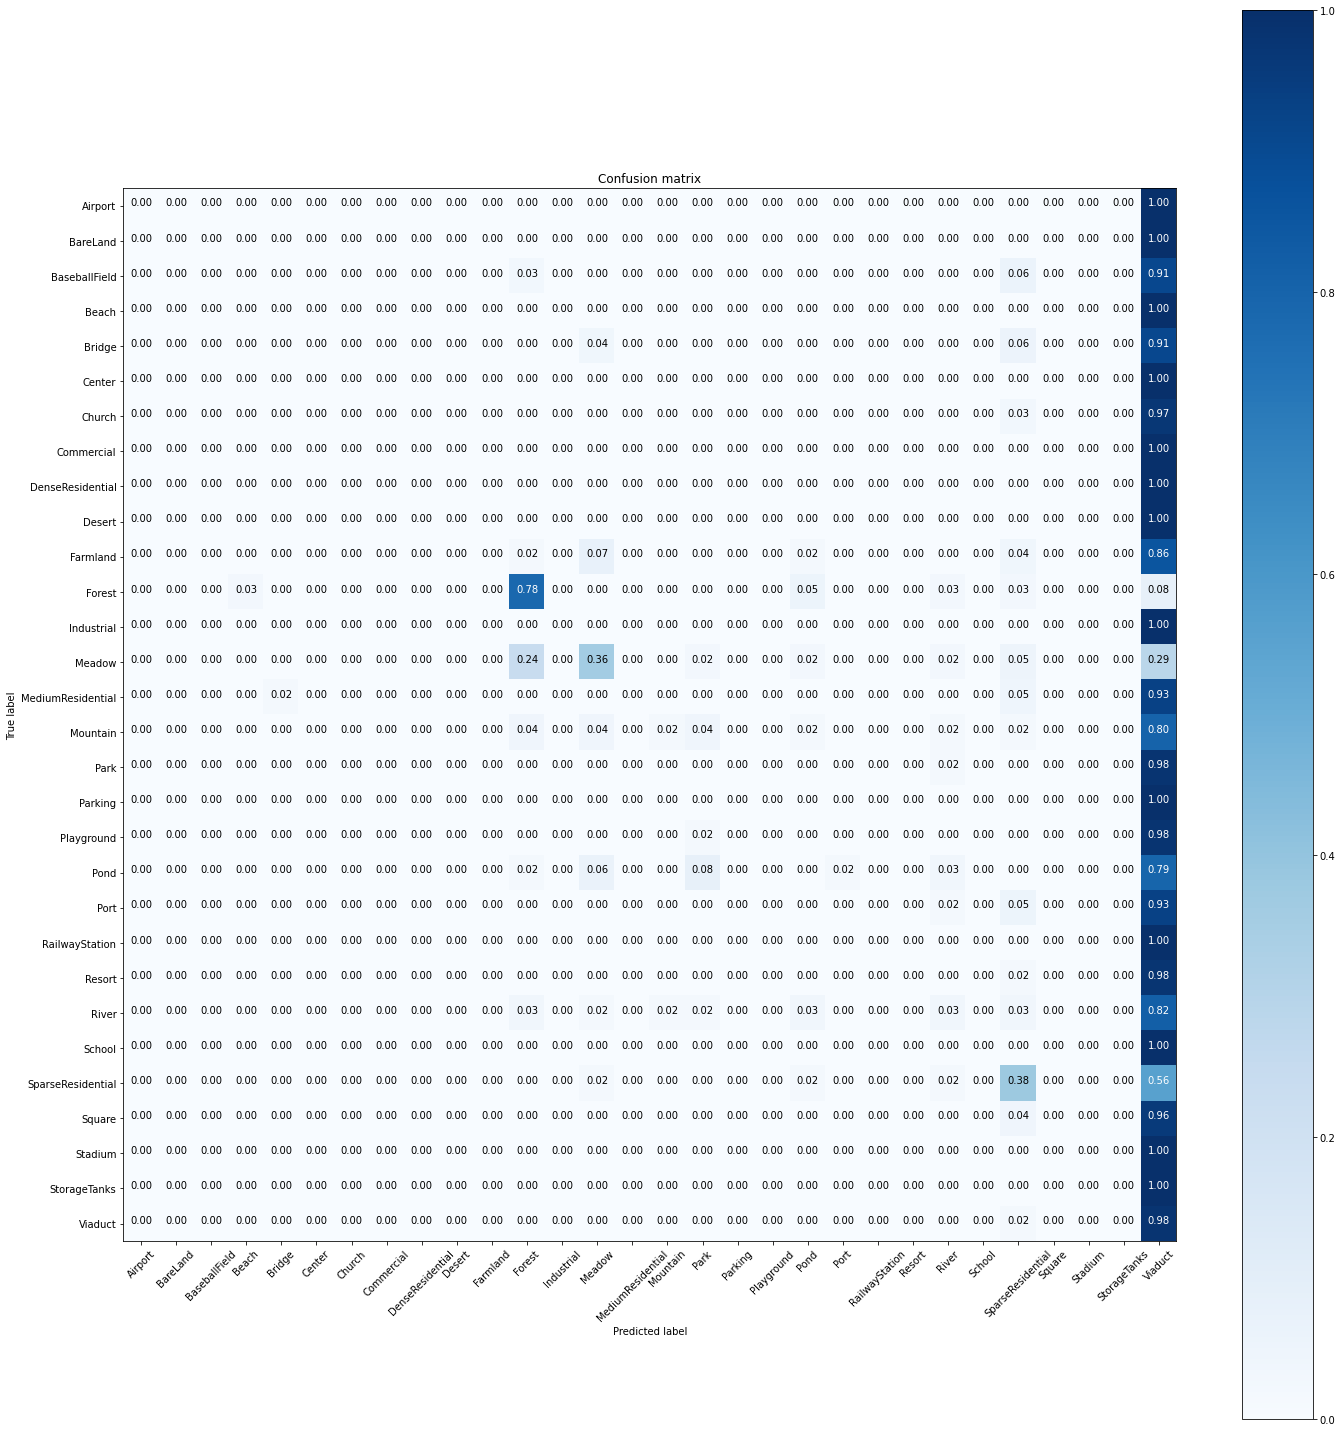

In [ ]:
# create mapping of class names to index and vice versa

class_to_idx = train_dataset.class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in train_dataset.class_to_idx.items()}

model_3.class_to_idx = train_dataset.class_to_idx
model_3.idx_to_class = {
    idx: class_
    for class_, idx in model_3.class_to_idx.items()
}

# Evaluate the model on all the test data

results, confusion_matrix = evaluate(model_3, test_loader, criterion)

# get confusion matrix plot

classnames = [model_3.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(20,20))
cfm_plot = plot_confusion_matrix(confusion_matrix, classnames)

In [ ]:
# compute test accuracy

test_acc = round(float(confusion_matrix.diag().sum()/confusion_matrix.sum())*100, 2)
print(f"Overall Accuracy: {test_acc}%")

Overall Accuracy: 8.4%


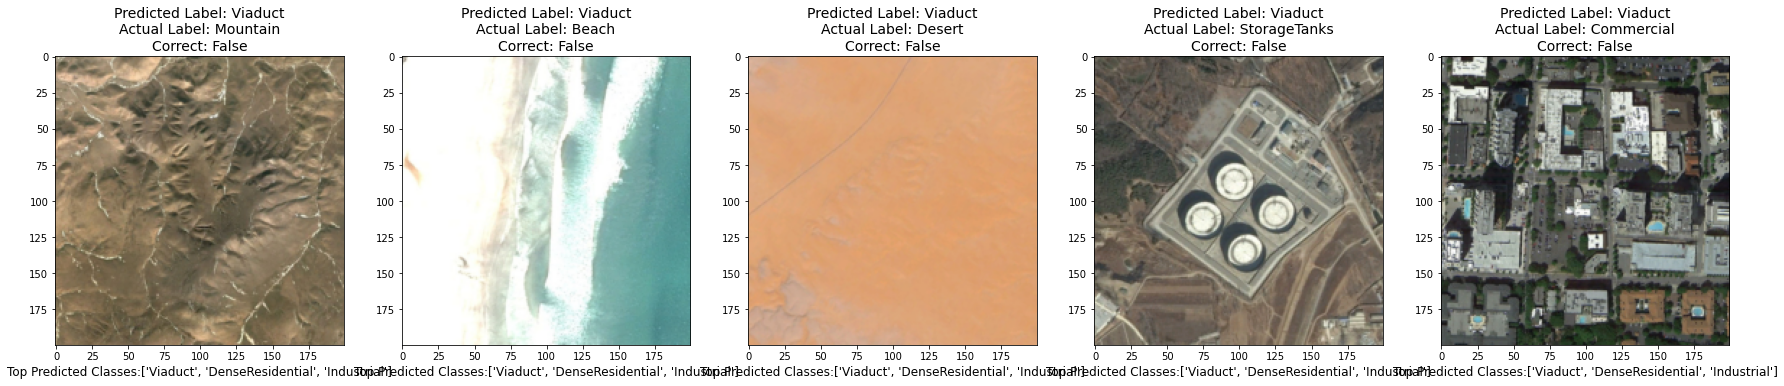

In [ ]:
# examine sample model inference

# load model for inference
model_3.load_state_dict(torch.load('best_model.pt'))
model_3.eval()

# convert image format
to_pil = transforms.ToPILImage()
# get sample images
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(30,30))
# make predictions and compare to True labels
for ii in range(len(images)):
    # image formatting for inference
    image = to_pil(images[ii])
    # get predictions
    index, class_probs = predict_image(image, model_3)
    # add to subplot
    sub = fig.add_subplot(1, len(images), ii+1)
    # calculate result
    res = int(labels[ii]) == index
    # predicted vs actual label
    sub.set_title('Predicted Label: ' + str(classes[index]) + '\nActual Label: ' + str(classes[labels[ii]]) + '\nCorrect: ' + str(res), fontsize=14)
    # top 3 most likely image classes according to model
    sub.set_xlabel('Top Predicted Classes:' + str(class_probs), fontsize=12)
    # format for display
    image = images[ii].numpy()
    imshow(image)
plt.show()

# 10. Analyze Results
- Which model performs better?
  - ResNet50 achieves 89% test accuracy while VGG16 achieves only 79% if trained for the same number of epochs (with early stopping).
  - Models using transfer learning perform significantly better than a simple CNN without substantial hyperparameter tuning. The basic CNN trained from scratch only achieves 8.27% accuracy and did not show noticable learning. It predicts predominantly one class for all images, except the forest class. It shows noticable underfitting and likely needs additional model complexity and learning time to learn.
  - This performance difference between the ResNet and VGG models from the Basic CNN demonstrates the power of transfer learning. The first two models are able to captialize on the existing learning of ResNet and VGG on ImageNet. With the MLP at the end to fine tune the first two models, we achieve 79-89% performance for the first two transfer learning models. 
- What class does the model perform best on? Show some sample images.
  - ResNet50 perform best on Beach, Mountain, Parking and Viaduct classes with 100% accuracy, 
  - The VVG16 model performs best on Viaduct (100%), Storage Tank (98%), Parking (97%),  Mountain(96%), Baseball Field (97%),  and Beach (90%) classes
- What class does it struggle to predict?
 - ResNet50 struggles with Square, School,  Railway Station,  and Resort classes that are below 70%.
 - The VVG16 struggles with Airport, Bareland, Church, Commercial, Farmland, Industrial, Meadow, Park,  Railway Station, and Stadium with less than 80 %. The worst performing classes are Resort, School, and Square.
